In this notebook we will reproduce the results for the transfer of a single particle in a three level system in a $\Lambda$-configuration. The particle will be initialized on the left-most level $\left(|1\rangle\right)$, and the target is to transfer it to the right side $\left(|3\rangle\right)$, with minimal population in the intermediate level $\left(|2\rangle\right)$. In this example, all the levels will be in resonance, so that the one-photon and two-photon detuning are zero. The coupling between levels are modified with a Stockes and Pump frequency, which will be the driving parameter.

The results to reproduce are those given in [A. Greentree, et. al, PRB **70**, 235317 (2014)](https://link.aps.org/doi/10.1103/PhysRevB.70.235317), Fig. 4.

In [3]:
# Import relevant functions and libraries

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from joblib import Parallel, delayed, parallel
from tqdm.auto import tqdm
import contextlib

The Hamiltonian, written on the basis $\left\{|1\rangle, |2\rangle, |3\rangle\right\}$ reads as ($\hbar=1$)

$$
H(t) = \left(
\begin{array}{ccc}
0 & \Omega_{12}(t) & 0 \\
\Omega_{12}(t) & 0 & \Omega_{23}(t) \\
0 & \Omega{23}(t) & 0
\end{array}\right).
$$

In [4]:
def hamiltonian_factory(Delta, Omega12, Omega23):
    """Hamiltonian for a three level system in a Lambda-configuration, with two-photon detuning equals to 0."""
    H = np.zeros((3, 3), dtype=complex)
    
    H[0, 0:] = [0, Omega12, 0]
    H[1, 1:] = [Delta, Omega23]
    H[2, 2:] = [0]
    
    H += H.T.conjugate() - np.diag(np.diag(H))
    return qt.Qobj(H)

The transfer protocol used here is known as Coherent Transfer by Adiabatic Passage (CTAP), where the driving pulses are modeled as Gaussian shapes with 

$$
\Omega_{12(23)}(t) = \Omega^\max \exp\left[-\left(t-\frac{t_\max \pm \sigma}{2}\right)^2/(2\sigma^2)\right],
$$
with a standard deviation fixed at $\sigma = t_\max / 8$.

In [5]:
def CTAP_pulse(time, Omega_max, time_max, sign=1):
    """Gaussian pulses for CTAP. sign=1 for the first pulse, sign=-1 for the second one."""
    sigma = time_max / 8
    return Omega_max * np.exp(- (time - time_max / 2 + sign * sigma / 2) ** 2 / (2 * sigma ** 2))

We include a pure dephasing which acts equally in all coherences. The Lindblad master equation to be solved reads

$$
\dot{\rho}(t) = -i\left[H(t),\rho(t)\right] + \sum_n\left[L_n\rho(t)L_n^\dagger - \frac{1}{2} \left\{\rho(t), L_n^\dagger L_n\right\}\right],
$$
where $L_n$ are the collapse opertator defined are the diagonal generalized Pauli matrices. For a three level system, these corresponds to the Gell-Mann matrices $\lambda_3$ and $\lambda_8$ defined as

$$
L_1 = \sqrt{\Gamma/2}\left(
\begin{array}{ccc}
1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & 0
\end{array}\right), \quad
L_2 = \sqrt{\Gamma/6} \left(
\begin{array}{ccc}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & -2
\end{array}\right),
$$
with $\Gamma$ the dephasing rate. Introducing these two operators in the master equation, we obtain the relation

$$
\dot{\rho}(t) = -i\left[H(t),\rho(t)\right] + \Gamma \left[\rho(t)-\mathrm{diag}\left(\rho(t)\right)\right].
$$

The same result can be obtained with the collapse operators acting on the idividual phases as

$$
L_1 = \sqrt{\Gamma}\left(
\begin{array}{ccc}
1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}\right), \quad
L_2 = \sqrt{\Gamma}\left(
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{array}\right), \quad
L_3 = \sqrt{\Gamma}\left(
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 1
\end{array}\right).
$$

In [6]:
def solve_dynamics(time_max, Gamma, Delta, Omega_max):
    """Solve the dynamics under CTAP and pure dephasing."""
    psi_0 = qt.basis(3, 0)
    time = np.linspace(0, time_max, 1000)
    
    if time_max == 0:
        return 0, np.array(qt.ket2dm(psi_0)).reshape((1, 3, 3))
    
    c_ops = [np.array([1, -1, 0]) * np.sqrt(Gamma / 2), np.array([1, 1, -2]) * np.sqrt(Gamma / 6)]
    c_ops = [qt.Qobj(np.diag(op)) for op in c_ops]

    H_0 = hamiltonian_factory(Delta, 0, 0)
    H_12 = [hamiltonian_factory(0, 1, 0), CTAP_pulse(time, Omega_max, time_max, sign=-1)]
    H_23 = [hamiltonian_factory(0, 0, 1), CTAP_pulse(time, Omega_max, time_max)]
    H_total = [H_0, H_12, H_23]
    
    rho_t = qt.mesolve(H_total, psi_0, time, c_ops=c_ops).states
    
    return time, np.array(rho_t)

def compute_populations(time_max, Gamma, Delta, Omega_max):
    """Obtain the population for each level after a CTAP."""
    time, rho_t = solve_dynamics(time_max, Gamma, Delta, Omega_max)
    populations = np.diagonal(rho_t, axis1=1, axis2=2).real
    return populations[-1]

In [7]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar."""
    class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = parallel.BatchCompletionCallBack
    parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [8]:
# General parameter

Delta = 0
Omega_max = 1

In [9]:
# Define the grid to compute the CTAP

n_tmax = 100
n_Gamma = 100
n_total = n_tmax * n_Gamma

tmax_vec = np.linspace(0, 10, n_tmax) * np.pi / Omega_max
Gamma_vec = np.linspace(0, 0.5, n_Gamma) * Omega_max

tmax_vec, Gamma_vec = [x.flatten() for x in np.meshgrid(tmax_vec, Gamma_vec)]

In [10]:
# Solve in paralel the transfer

with tqdm_joblib(tqdm(range(n_total), desc="Computing noisy transfer")) as pbar:
    populations = Parallel(n_jobs=-1)(delayed(compute_populations)(tmax_vec[j], Gamma_vec[j],
                                                                   Delta, Omega_max) for j in range(n_total))
    
populations = np.array(populations).reshape(n_Gamma, n_tmax, 3)

Computing noisy transfer:   0%|          | 0/10000 [00:00<?, ?it/s]

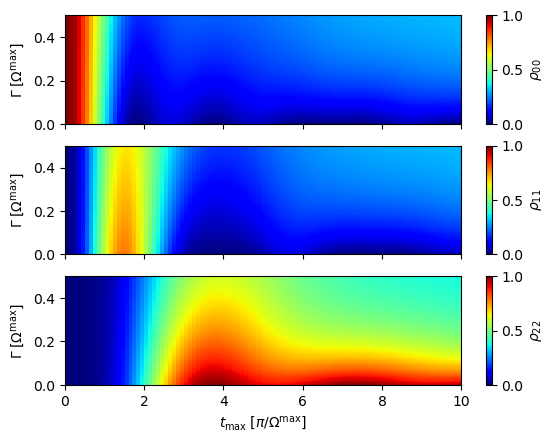

In [11]:
# Plot the results

fig, axs = plt.subplots(3, sharex=True, sharey=True)

for i in range(3):
    im = axs[i].imshow(populations[:, :, i], origin='lower', aspect='auto', vmin=0, vmax=1, cmap='jet',
                       extent=[min(tmax_vec) / (np.pi / Omega_max), max(tmax_vec) / (np.pi / Omega_max),
                               min(Gamma_vec) / Omega_max, max(Gamma_vec) / Omega_max],
                       interpolation='None')
    
    index = str(i) * 2
    cbar = fig.colorbar(im, ax=axs[i])
    cbar.ax.set_ylabel(r'$\rho_{' + f'{index}' + '}$')
    
axs[2].set_xlabel(r'$t_\max\;[\pi/\Omega^\max]$')
[ax.set_ylabel(r'$\Gamma \; [\Omega^\max]$') for ax in axs];